In [1]:
import logging
import numpy as np
import pandas as pd
import tensorflow as tf
import keras

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
log = logging.getLogger()

%config Completer.use_jedi = False # make autocompletion works in jupyter

tf.__version__

'2.4.1'

In [2]:
import argparse
import numpy as np
import pandas as pd
from pathlib import Path

args = argparse.Namespace()

args.n_splits = 5
args.n_jobs = -1
args.val_fraction = 0.1
args.epochs = 50
args.seed=101
args.reproducibility = True

args.run_baseline = True

args.raw_train = pd.read_csv('../data/train.csv.zip')
args.raw_test = pd.read_csv('../data/test.csv.zip')
args.train = args.raw_train.iloc[:, 1:].copy()
args.labels = args.raw_train['label'].copy()
args.test = args.raw_test.copy()
args.predictions_folder = Path('../predictions/best')
args.models_folder = Path('../models/best')

args.model_name = 'best.hdf5'

args.predictions_folder.mkdir(parents=True, exist_ok=True) 
args.models_folder.mkdir(parents=True, exist_ok=True) 

In [3]:
import tensorflow as tf

def reproducibility():
    if args.reproducibility:
#     np.random.seed(args.seed)
#     random.seed(args.seed)
        tf.random.set_seed(args.seed)

reproducibility()

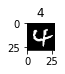

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def draw_digit(pixels_2d, label=None, size_inches=None):
    fig, ax = plt.subplots()
    if label is not None:
        ax.set_title(label)
    if size_inches:
        fig.set_size_inches(size_inches[0], size_inches[1])
    imgplot = ax.imshow(pixels_2d, cmap='gray')

random_row = random.randrange(0, args.raw_train.shape[0], 1)
label = args.raw_train.iloc[random_row, 0]
pixels_2d = args.raw_train.iloc[random_row, 1:].to_numpy().reshape(28, 28)
draw_digit(pixels_2d, label, (0.5, 0.5))

In [5]:
import sklearn.utils.multiclass

X_train = args.train.to_numpy().reshape(args.train.shape[0], 28, 28, 1)
Y_train = pd.get_dummies(args.labels, prefix='label').to_numpy()
y_train = args.labels.to_numpy()
X_test = args.test.to_numpy().reshape(args.test.shape[0], 28, 28, 1)

log.info('X.shape: %s', repr(X_train.shape))
# log.info('X[0][14][14]: %s', X[0][14][14])

log.info('Y_train.shape: %s', repr(Y_train.shape))
# log.info('y[0], %s', y[0])
log.info('Type of target Y_train: %s', repr(sklearn.utils.multiclass.type_of_target(Y_train)))

log.info('y_train.shape: %s', repr(y_train.shape))
# log.info('y_sparse: %s', repr(y_sparse))
# log.info('y_sparse[0]: %s', y_sparse[0])
log.info('Type of target y_train: %s', repr(sklearn.utils.multiclass.type_of_target(y_train)))

def plot_history(history):
    log.info("History keys: %s", history.history.keys())
    # Accuracy
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(history.history['accuracy'], label='Train')
    ax.plot(history.history['val_accuracy'], label='Test')
    ax.set_title('Model accuracy')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.grid(True)
    ax.legend(['Train', 'Val'], loc='lower right')
    
    # Loss
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.grid()
    plt.show()
    
    
def csv_predictions(predictions, filename):
    log.debug('predictions.shape: %s', repr(predictions.shape))
    predictions_classes = np.argmax(predictions, axis=1)
    image_ids = np.arange(1, len(predictions_classes) + 1)
    submission = pd.DataFrame({'ImageId': image_ids, 'Label': predictions_classes})
    filepath = args.predictions_folder/filename
    submission.to_csv(filepath, index=False)
    log.info('Saved file: %s', filepath)


2021-04-24 23:06:56,256 : INFO : X.shape: (42000, 28, 28, 1)
2021-04-24 23:06:56,262 : INFO : Y_train.shape: (42000, 10)
2021-04-24 23:06:56,305 : INFO : Type of target Y_train: 'multilabel-indicator'
2021-04-24 23:06:56,310 : INFO : y_train.shape: (42000,)
2021-04-24 23:06:56,380 : INFO : Type of target y_train: 'multiclass'


### Baseline

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0

2021-04-24 23:43:43,080 : INFO : History keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping


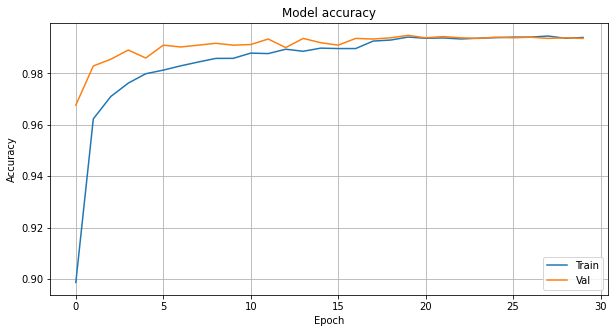

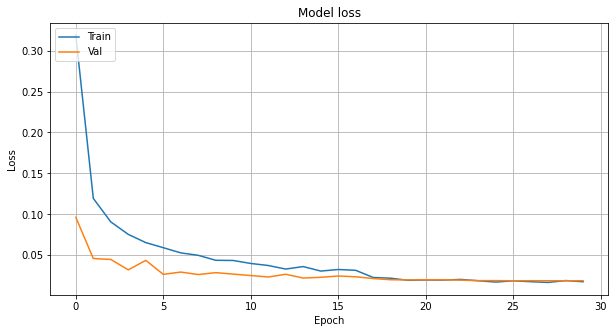

2021-04-24 23:43:56,637 : INFO : Saved file: ../predictions/best/baseline.csv


AssertionError: 

In [6]:
from tensorflow import keras

def baseline1():
    reproducibility()
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(28, 28, 1)))
    
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(0.4))
    
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(0.4))
    
    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.4))
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'))
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    model.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print(model.summary())
    
    monitor='val_accuracy'
    early_stopping = keras.callbacks.EarlyStopping(monitor=monitor, patience=10, mode='auto', restore_best_weights=True, verbose=1)
#     model_checkpoint = keras.callbacks.ModelCheckpoint(args.model_name, save_best_only=True, monitor=monitor, mode='auto', verbose=2)
    reduce_lr_on_plateau = keras.callbacks.ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=3, min_delta=1e-4, mode='auto', verbose=1)
    
    history = model.fit(X_train, y_train, validation_split=args.val_fraction, epochs=args.epochs, batch_size=32,
                        verbose=1, callbacks=[early_stopping, reduce_lr_on_plateau])
    plot_history(history)
    
    predictions = model.predict(X_test)
    csv_predictions(predictions, 'baseline.csv')

baseline1()
assert False

In [ ]:
from tensorflow import keras

def baseline():
    reproducibility()
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(28, 28, 1)))
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    model.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print(model.summary())
    
    monitor='val_accuracy'
    early_stopping = keras.callbacks.EarlyStopping(monitor=monitor, patience=10, mode='auto', restore_best_weights=True, verbose=1)
#     model_checkpoint = keras.callbacks.ModelCheckpoint(args.model_name, save_best_only=True, monitor=monitor, mode='auto', verbose=2)
    reduce_lr_on_plateau = keras.callbacks.ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=3, min_delta=1e-4, mode='auto', verbose=1)
    
    history = model.fit(X_train, y_train, validation_split=args.val_fraction, epochs=args.epochs, batch_size=32,
                        verbose=1, callbacks=[early_stopping, reduce_lr_on_plateau])
    plot_history(history)
    
    predictions = model.predict(X_test)
    csv_predictions(predictions, 'baseline.csv')

baseline()

| Model | Params  | Test score  | CV mean score |
|---|---|---|---|
| Baseline | No dropout | 0.99017 | 0.9924 |
| Baseline | Dropout=0.4 | 0.99200 | 0.9931 |


##### Other results
| Model | Params  | Test score  | CV mean score |
|---|---|---|---|
| Baseline | Dropout=0.25 (after 2 first conv) | 0.99150 | 0.9929 |
| Baseline | Dropout=0.5 (after 2 first conv) | 0.99178 | 0.9924 |
| Baseline | Dropout=0.5  | 0.98867 | 0.9912 |
| Baseline | Dropout=0.3  | 0.99182 |  0.9936 |
| Baseline | Dropout=0.4 batch normalization before activation  | 0.99275 |  0.9929 |
| Baseline | Dropout=0.4 batch normalization  | 0.99403 |  0.9952 |
| Baseline | Dropout=0.4 batch normalization he normal | 0.99260 |  0.9948 |